# TEST CONVOLUTION LAYER
This notebook recreate each CNN layers in Qm.n format or keras format
It aims to understand how each layer works

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from itertools import product

import warnings
warnings.filterwarnings('ignore')

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [15, 5]

In [2]:
'''
    Prepare the features
'''
dataset = pd.read_csv("C:/Temp/k2arm/models/feat_fft_50_150.csv")
dataset = dataset.drop(dataset.columns[0], axis=1)
y_data = dataset['FlowRate'].astype(float).to_numpy()
x_data = dataset.drop(['FlowRate'], axis=1).to_numpy()

max_train = y_data.max()
min_train = y_data.min()

x_data_n = x_data.reshape((x_data.shape[0],x_data.shape[1], 1))
y_data_n = (y_data-min_train) / (max_train - min_train)
print(x_data_n.shape)
print(y_data.shape)

(856, 82, 1)
(856,)


### Usefull function for Qm.n format

In [12]:
MODEL_INT = False
model_ref_path = 'C:\Temp\k2arm\models\cnn_model_tanh.h5'

def findQRangeOfWeights(weights):
    """ Finds the Q Range which does not clip the weights

    weights: float values of which the ideal Q range is searched
    returns: number of integer bits required to represent "weights"
    """
    qRange = [None]*(15 + 1)
    for bit in range(0, 15 + 1):
        qRange[bit] = findQR(bit)

    minValue = weights.min()
    maxValue = weights.max()
    highestVal = max(abs(minValue), abs(maxValue))
    for bit in range(0, 15 + 1):
        if highestVal < qRange[bit][1]:
            # highestVal fits in the range
            # return number of integer bits required
            return bit

def findQR(intBits):
    """ Calculate the range, given the number of integer bits QM.N

    intBits: number of bits used for integer part
    """
    M = intBits
    N = 15 - M
    [minVal, maxVal] = [-2**(M - 1), (2**(M - 1) - 2**(-N))]
    return [minVal, maxVal]

def weightsCalculation(weightsArray, shift_bias, shift_out):
    """ 
        Calculate the weights Qm.n format
    """
    if MODEL_INT == False:
        return weightsArray
    idx = 0
    for weights in weightsArray:
        intBit = findQRangeOfWeights(weights)
        print("QRange of Weights : ", intBit)
        # if we have q15 we can buffer the int bits. This increases stability
        # in q7 mode this does sometimes decrease the accuracy to much
        intBit = intBit + 2
        decBit = 15 - intBit
        print("Dec bit = ", decBit)

        # convert to q format using same method as ARM [1]
        intWeights = np.round(weights * 2**decBit)

        # saturate range inside q7 or q15 to prevent sign cast in C code
        intWeights[intWeights > 2**15 -1] = 2**15 - 1
        intWeights[intWeights < -2**15] = - 2**15
        if idx == 1:
            weightsArray[idx] = intWeights * 2**shift_bias + shift_out
        else:
            weightsArray[idx] = intWeights
        
        idx = idx + 1
    return weightsArray

## Convolution Layer

In [13]:
CONV1D_SHIFT_BIAS = 0
CONV1D_SHIFT_OUT = 9

input_shape = x_data_n.shape[1:]
print(input_shape)
input_layer = keras.layers.Input(input_shape)
p_l = keras.layers.Conv1D(filters=32, 
                          kernel_size=6, 
                          kernel_initializer='he_uniform')(input_layer)
output_layer = keras.layers.Activation('relu')(p_l)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)

model_ref = keras.models.load_model(model_ref_path)
model.layers[1].set_weights(model_ref.layers[1].get_weights())
weightsArray = model.layers[1].get_weights()
print("Max/Min Weights = ", weightsArray[0].max(), weightsArray[0].min())
print("Max/Min Bias = ", weightsArray[0].max(), weightsArray[0].min())
weightsArray = weightsCalculation(weightsArray, CONV1D_SHIFT_BIAS, CONV1D_SHIFT_OUT)
model.layers[1].set_weights(weightsArray)
#print(model.layers[1].get_weights()[0])

(82, 1)
Max/Min Weights =  1.0456904 -1.0791551
Max/Min Bias =  1.0456904 -1.0791551


7807.3667 0.0
[16.798239    0.          0.          2.6130848   0.         19.85649
  0.          7.3753834   0.         10.279577    0.         17.115402
  0.         22.87435     0.          4.3985305   0.          0.
  0.         21.973515    0.         14.444917    0.          0.
  0.12521562  0.         19.547237   12.676333   12.3872175   0.
  0.         18.811178  ]
(856, 77, 32)


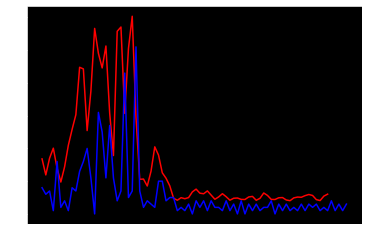

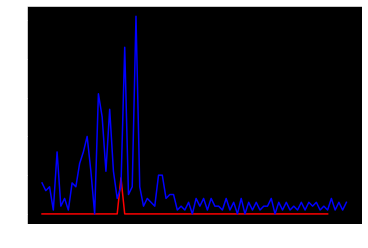

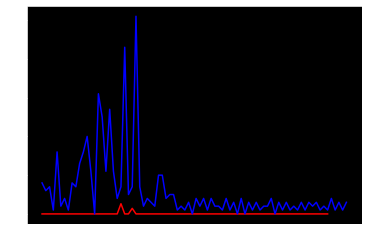

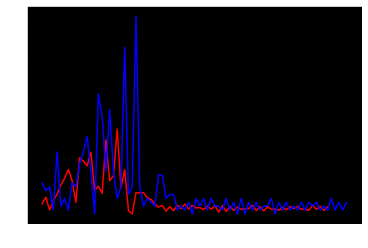

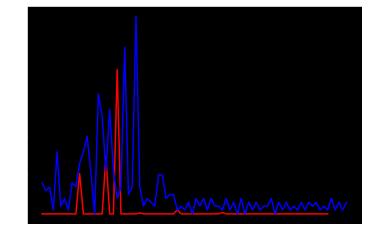

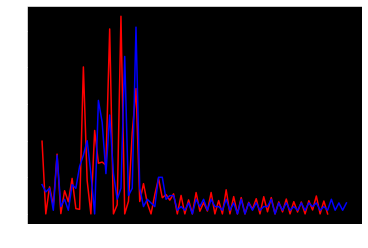

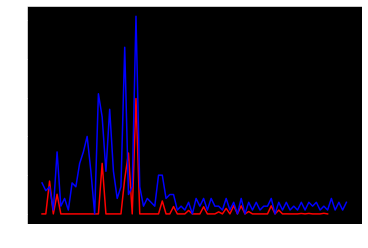

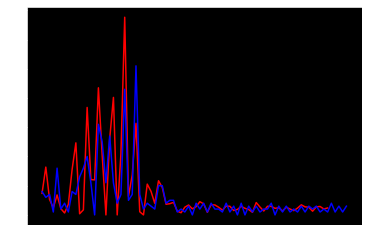

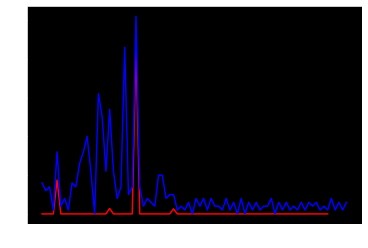

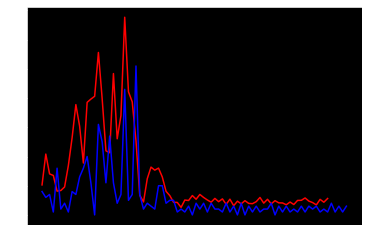

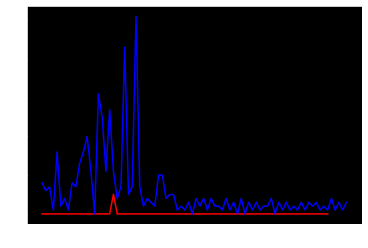

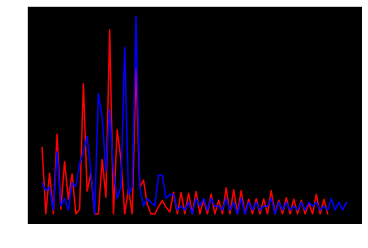

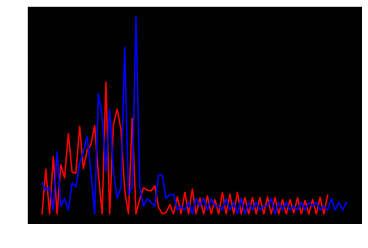

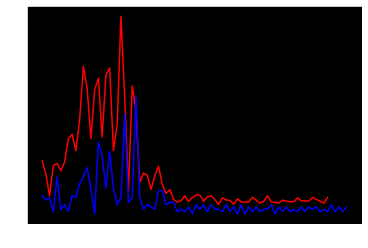

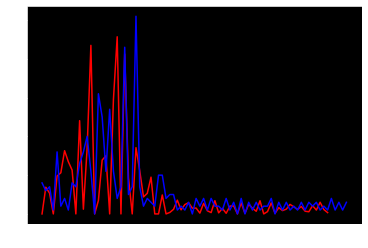

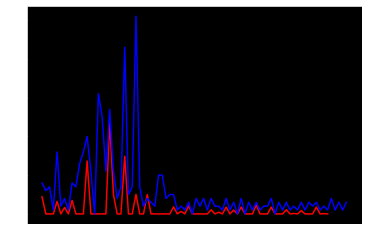

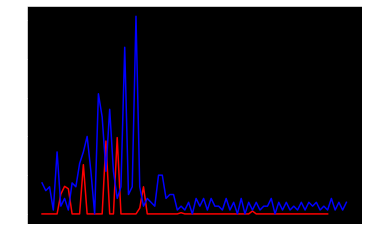

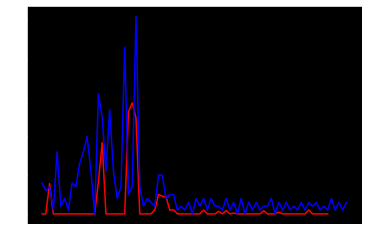

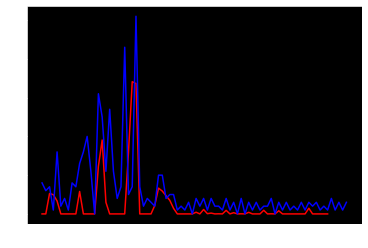

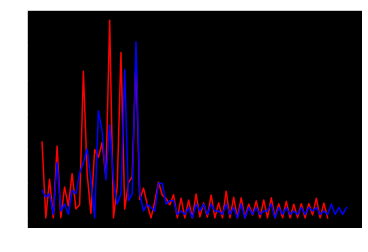

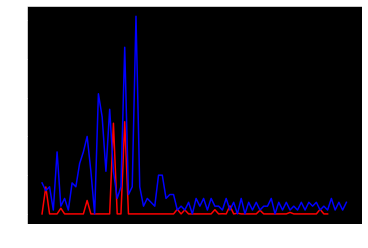

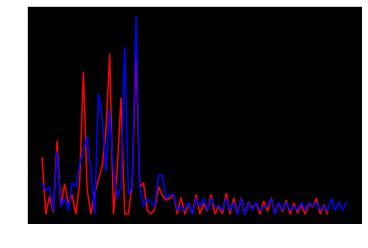

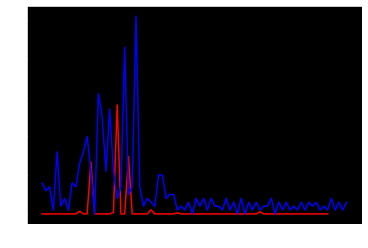

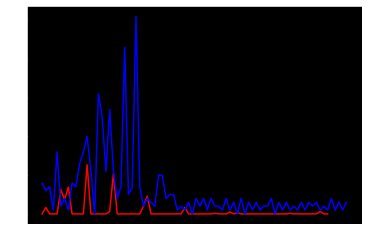

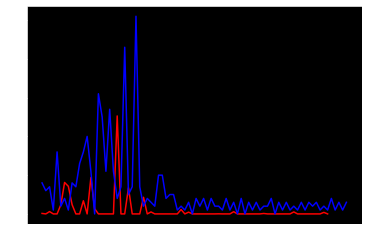

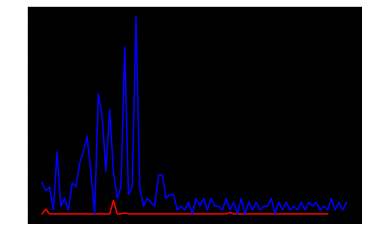

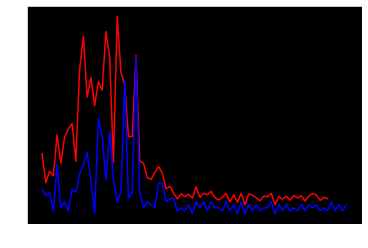

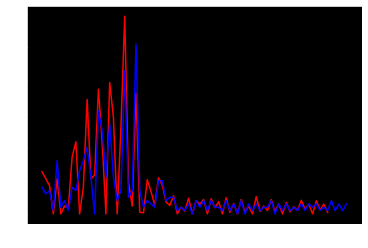

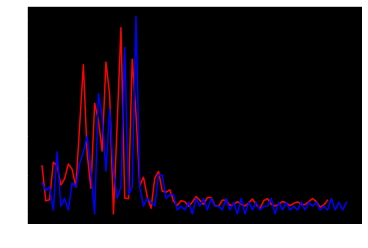

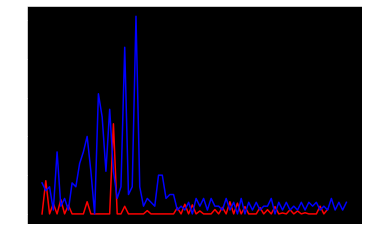

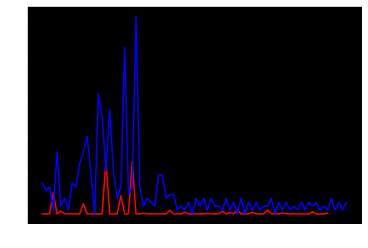

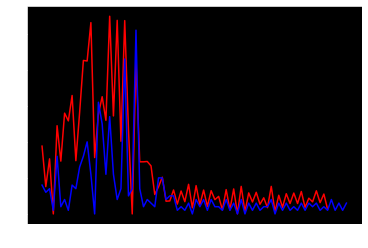

In [15]:
if MODEL_INT:
    pred_1 = model.predict(x_data_n) / (2**CONV1D_SHIFT_OUT)
    pred_1 = pred_1.astype(int)
else:
    pred_1 = model.predict(x_data_n)
print(np.max(pred_1), np.min(pred_1))
print(pred_1[0][:][0])
print(pred_1.shape)
trans = np.transpose(pred_1[0])
for t in trans:
    plt.plot(t, 'r')
    plt.plot(x_data_n[0], 'b')
    plt.show()

## Convolution 1D 2

In [1294]:
CONV1D_SHIFT_BIAS = 2
CONV1D_SHIFT_OUT = 12

input_shape = pred_1.shape[1:]
print(input_shape)
input_layer = keras.layers.Input(input_shape)
output_layer = keras.layers.Conv1D(filters=32, 
                          kernel_size=6, 
                          kernel_initializer='he_uniform')(input_layer)
output_layer = keras.layers.Activation('relu')(output_layer)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)

model_ref = keras.models.load_model(model_ref_path)
model.layers[1].set_weights(model_ref.layers[3].get_weights())
weightsArray = model.layers[1].get_weights()
weightsArray = weightsCalculation(weightsArray, CONV1D_SHIFT_BIAS, CONV1D_SHIFT_OUT)
model.layers[1].set_weights(weightsArray)
#print(model.layers[1].get_weights()[0][0])

(77, 32)
QRange of Weights :  0
Dec bit =  13
QRange of Weights :  0
Dec bit =  13


In [1295]:
if MODEL_INT:
    pred_2 = model.predict(pred_1) / (2**CONV1D_SHIFT_OUT)
    pred_2 = pred_2.astype(int)
else:
    pred_2 = model.predict(pred_1)
print(np.max(pred_2), np.min(pred_2))
print(pred_2[0][0])

23123 0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## Convolution 1D 3

In [1296]:
CONV1D_SHIFT_BIAS = 3
CONV1D_SHIFT_OUT = 12

input_shape = pred_2.shape[1:]
print(input_shape)
input_layer = keras.layers.Input(input_shape)
p_l = keras.layers.Conv1D(filters=32, 
                          kernel_size=6, 
                          kernel_initializer='he_uniform')(input_layer)
output_layer = keras.layers.Activation('relu')(p_l)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)

model_ref = keras.models.load_model(model_ref_path)

model.layers[1].set_weights(model_ref.layers[5].get_weights())
weightsArray = model.layers[1].get_weights()
weightsArray = weightsCalculation(weightsArray, CONV1D_SHIFT_BIAS, CONV1D_SHIFT_OUT)
model.layers[1].set_weights(weightsArray)
#print(model.layers[1].get_weights()[0][0].shape)

(72, 32)
QRange of Weights :  0
Dec bit =  13
QRange of Weights :  0
Dec bit =  13


In [1297]:
if MODEL_INT:
    pred_3 = model.predict(pred_2) / (2**CONV1D_SHIFT_OUT)
    pred_3 = pred_3.astype(int)
else:
    pred_3 = model.predict(pred_2)
print(np.max(pred_3), np.min(pred_3))
print(pred_3[0][0])

20620 0
[ 0  7  0  0  0  0  0  0  0  0  0 27  0  0  0  0  0  0  0  0  0  2  0  0
  0  0  0  0  0  0  0  0]


## Global Average Pooling Layer

In [1298]:
input_shape = pred_3.shape[1:]
print(input_shape)
input_layer = keras.layers.Input(input_shape)
output_layer = keras.layers.GlobalAveragePooling1D()(input_layer)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)
model.summary()

pooling = model.predict(pred_3)
if MODEL_INT:
    pooling = pooling.astype(int)
print(pooling[0])
print(pooling.max())

(67, 32)
Model: "model_545"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_549 (InputLayer)       [(None, 67, 32)]          0         
_________________________________________________________________
global_average_pooling1d_105 (None, 32)                0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
[ 1  6 13  7  0  0  7  3  3  3  2  4  8  3  7  6  6  2  4  1  1  6  0  4
  5  3  3  2  2  0  0  5]
1154


## DENSE LAYER 1

In [1299]:
DENSE_1_SHIFT_BIAS = 4
DENSE_1_SHIFT_OUT = 8

input_shape = pooling.shape[1]
print(input_shape)
input_layer = keras.layers.Input(input_shape)
p_l = keras.layers.Dense(32)(input_layer)
output_layer = keras.layers.Activation('relu')(p_l)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)
model.summary()

model_ref = keras.models.load_model(model_ref_path)
model.layers[1].set_weights(model_ref.layers[8].get_weights())
weightsArray = model.layers[1].get_weights()
weightsArray = weightsCalculation(weightsArray, DENSE_1_SHIFT_BIAS, DENSE_1_SHIFT_OUT)
model.layers[1].set_weights(weightsArray)
# print(model.layers[1].get_weights())

32
Model: "model_546"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_550 (InputLayer)       [(None, 32)]              0         
_________________________________________________________________
dense_319 (Dense)            (None, 32)                1056      
_________________________________________________________________
activation_601 (Activation)  (None, 32)                0         
Total params: 1,056
Trainable params: 1,056
Non-trainable params: 0
_________________________________________________________________
QRange of Weights :  0
Dec bit =  13
QRange of Weights :  0
Dec bit =  13


In [1300]:
if MODEL_INT:
    dense = model.predict(pooling) / (2**DENSE_1_SHIFT_OUT)
    dense = dense.astype(int)
else:
    dense = model.predict(pooling)
print(np.max(dense), np.min(dense))
print(dense[0])

22616 0
[151   7   6   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
 102   0  72   0   0  25   0  92   0 293  28   0   0  18]


## Dense Layer 2

In [1301]:
DENSE_2_SHIFT_BIAS = 9
DENSE_2_SHIFT_OUT = 11

input_shape = dense.shape[1]
print(input_shape)
input_layer = keras.layers.Input(input_shape)
p_l = keras.layers.Dense(32)(input_layer)
output_layer = keras.layers.Activation('relu')(p_l)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)
model.summary()

model_ref = keras.models.load_model(model_ref_path)
model.layers[1].set_weights(model_ref.layers[10].get_weights())
weightsArray = model.layers[1].get_weights()
weightsArray = weightsCalculation(weightsArray, DENSE_2_SHIFT_BIAS, DENSE_2_SHIFT_OUT)
model.layers[1].set_weights(weightsArray)
# print(model.layers[1].get_weights())

32
Model: "model_547"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_551 (InputLayer)       [(None, 32)]              0         
_________________________________________________________________
dense_320 (Dense)            (None, 32)                1056      
_________________________________________________________________
activation_602 (Activation)  (None, 32)                0         
Total params: 1,056
Trainable params: 1,056
Non-trainable params: 0
_________________________________________________________________
QRange of Weights :  0
Dec bit =  13
QRange of Weights :  0
Dec bit =  13


In [1302]:
if MODEL_INT:
    dense2 = model.predict(dense) / (2**DENSE_2_SHIFT_OUT)
    dense2 = dense2.astype(int)
else:
    dense2 = model.predict(dense)
print(np.max(dense2), np.min(dense2))
print(dense2[0])

35064 0
[  0 181   7   0 211   0   0 107   0 418   0   0   0   0  72  75 275   0
   0   0   0 770   0 340   0 216   0  77   0 228 310   0]


## Dense Layer Output

In [1303]:
DENSE_3_SHIFT_BIAS = 11
DENSE_3_SHIFT_OUT = 13

input_shape = dense2.shape[1]
print(input_shape)
input_layer = keras.layers.Input(input_shape)
output_layer = keras.layers.Dense(1)(input_layer)
#output_layer = keras.layers.Activation('tanh')(output_layer)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)
model.summary()

model_ref = keras.models.load_model(model_ref_path)
model.layers[1].set_weights(model_ref.layers[12].get_weights())
weightsArray = model.layers[1].get_weights()
weightsArray = weightsCalculation(weightsArray, DENSE_3_SHIFT_BIAS, DENSE_1_SHIFT_OUT)
model.layers[1].set_weights(weightsArray)
#print(model.layers[1].get_weights())

32
Model: "model_548"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_552 (InputLayer)       [(None, 32)]              0         
_________________________________________________________________
dense_321 (Dense)            (None, 1)                 33        
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
QRange of Weights :  0
Dec bit =  13
QRange of Weights :  0
Dec bit =  13


20015 -113
17868.8 4710.4


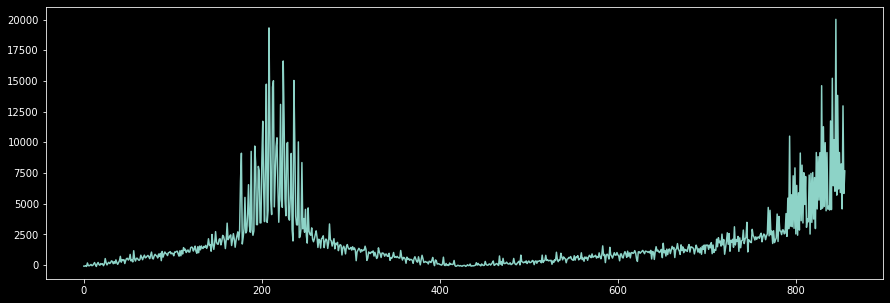

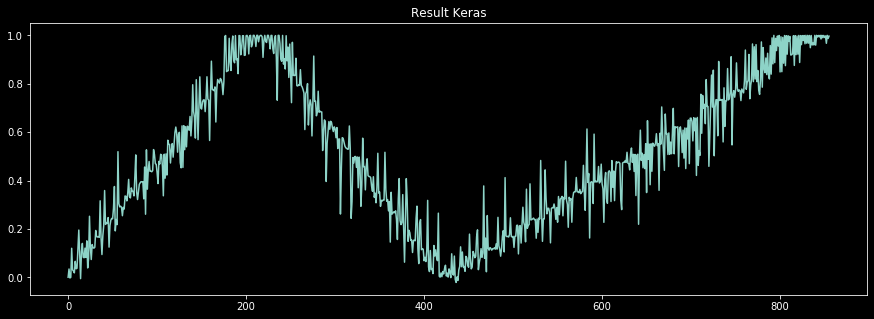

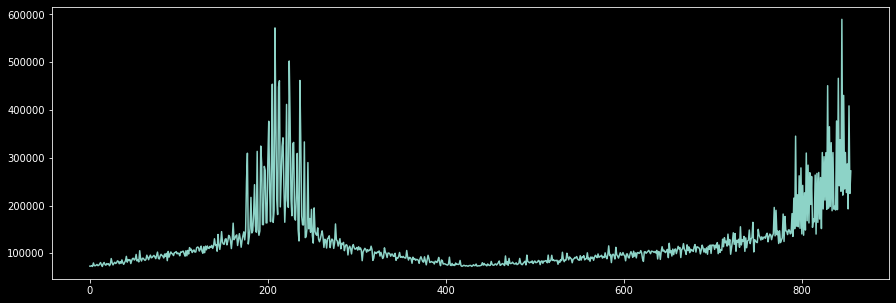

In [1306]:
if MODEL_INT:
    output = model.predict(dense2) / (2**DENSE_3_SHIFT_OUT)
    output = output.astype(int)
else:
    output = model.predict(dense2)
    
#output = output / 2**11
#output = np.tanh(output)
print(np.max(output), np.min(output))
# Min/max format = Q6.9
max_train_q = y_data.max() * 2**9
min_train_q = y_data.min() * 2**9

print(max_train_q, min_train_q)

# Q2.13 * Q6.9 = Q9.22 => min_train_q << 13
final = output * (max_train_q - min_train_q) + (min_train_q * 2**13)
# Q9.22 => Q2.13
final = (final / 2**9).astype(int)

final_float = (final / 2**13)
# Plot direct output before activation with Qm.n format
plt.plot(output)
plt.show()
# Plot real prediction from Keras model
model_ref = keras.models.load_model(model_ref_path)
pred = model_ref.predict(x_data_n)
plt.title("Result Keras")
plt.plot(pred)
plt.show()
# Plot final result with Qm.n format
plt.plot(final)
plt.show()


## Test rebuild

In [917]:
model_ref = keras.models.load_model('C:\Temp\k2arm\models\cnn_model.h5')
# rebuild each layer and gives the min/max value of the weights
max_weight_bias = 0
min_weight_bias = 0
for layer in model_ref.layers:
    if 'dense' in layer.name:
        if np.max(layer.get_weights()[0]) > max_weight_bias :
            max_weight_bias = np.max(layer.get_weights()[0])
        if np.max(layer.get_weights()[1]) > max_weight_bias :
            max_weight_bias = np.max(layer.get_weights()[1])
        if np.min(layer.get_weights()[0]) < min_weight_bias :
            min_weight_bias = np.min(layer.get_weights()[0])
        if np.min(layer.get_weights()[1]) < min_weight_bias :
            min_weight_bias = np.min(layer.get_weights()[1])
    elif 'conv1d' in layer.name:
        if np.max(layer.get_weights()[0]) > max_weight_bias :
            max_weight_bias = np.max(layer.get_weights()[0])
        if np.max(layer.get_weights()[1]) > max_weight_bias :
            max_weight_bias = np.max(layer.get_weights()[1])
        if np.min(layer.get_weights()[0]) < min_weight_bias :
            min_weight_bias = np.min(layer.get_weights()[0])
        if np.min(layer.get_weights()[1]) < min_weight_bias :
            min_weight_bias = np.min(layer.get_weights()[1])
print("Max Weight Bias : ", max_weight_bias)
print("Min Weight Bias : ", min_weight_bias)

def weightsCalculationEqual(weightsArray, shift_bias, shift_out):
    idx = 0
    for weights in weightsArray:
        # convert to q format using same method as ARM [1]
        intWeights = np.round(weights * 10000)

        # saturate range inside q7 or q15 to prevent sign cast in C code
        intWeights[intWeights > 2**15 -1] = 2**15 - 1
        intWeights[intWeights < -2**15] = - 2**15
        if idx == 1:
            weightsArray[idx] = intWeights * 2**shift_bias + shift_out
        else:
            weightsArray[idx] = intWeights
        
        idx = idx + 1
    return weightsArray

Max Weight Bias :  0.97727615
Min Weight Bias :  -1.0170494


(82, 1)
QRange of Weights :  2
QRange of Weights :  0
QRange of Weights :  0
QRange of Weights :  0
QRange of Weights :  0
QRange of Weights :  0
QRange of Weights :  0
QRange of Weights :  0
QRange of Weights :  0
QRange of Weights :  0
QRange of Weights :  0
QRange of Weights :  0
4158.0
[5.7735845e+22]
[-6.322313e+21]


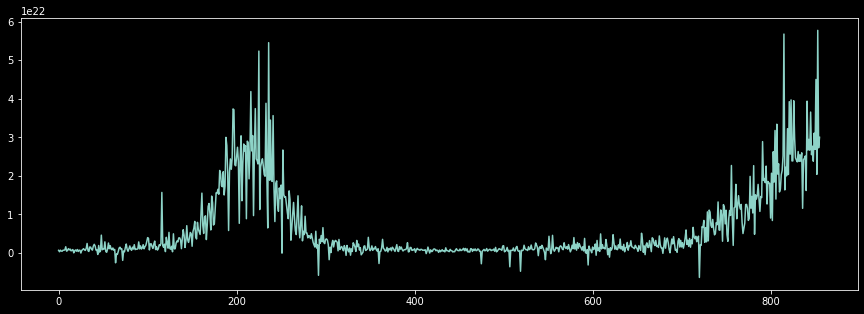

In [918]:
input_shape = x_data_n.shape[1:]
print(input_shape)
input_layer = keras.layers.Input(input_shape)
p_l = keras.layers.Conv1D(filters=32, 
                          kernel_size=6, 
                          padding='same',
                          kernel_initializer='he_uniform')(input_layer)
p_l = keras.layers.Activation('relu')(p_l)
p_l = keras.layers.Conv1D(filters=32, 
                          kernel_size=6, 
                          padding='same',
                          kernel_initializer='he_uniform')(p_l)
p_l = keras.layers.Activation('relu')(p_l)
p_l = keras.layers.Conv1D(filters=32, 
                          kernel_size=6, 
                          padding='same',
                          kernel_initializer='he_uniform')(p_l)
p_l = keras.layers.Activation('relu')(p_l)
p_l = keras.layers.GlobalAveragePooling1D()(p_l)
p_l = keras.layers.Dense(32)(p_l)
p_l = keras.layers.Activation('relu')(p_l)
p_l = keras.layers.Dense(32)(p_l)
p_l = keras.layers.Activation('relu')(p_l)
p_l = keras.layers.Dense(1)(p_l)
# p_l = keras.layers.Activation('tanh')(p_l)
model = keras.models.Model(inputs=input_layer, outputs=p_l)

model_ref = keras.models.load_model('C:\Temp\k2arm\models\cnn_model.h5')
# Layer Conv1D 1
weightsArray = model_ref.layers[1].get_weights()
weightsArray = weightsCalculation(weightsArray, 0, 0)
model.layers[1].set_weights(weightsArray)
# Layer Conv1D 2
weightsArray = model_ref.layers[3].get_weights()
weightsArray = weightsCalculation(weightsArray, 0, 0)
model.layers[3].set_weights(weightsArray)
# Layer Conv1D 3
weightsArray = model_ref.layers[5].get_weights()
weightsArray = weightsCalculation(weightsArray, 0, 0)
model.layers[5].set_weights(weightsArray)
# Layer Dense 1
weightsArray = model_ref.layers[8].get_weights()
weightsArray = weightsCalculation(weightsArray, 0, 0)
model.layers[8].set_weights(weightsArray)
# Layer Dense 2
weightsArray = model_ref.layers[10].get_weights()
weightsArray = weightsCalculation(weightsArray, 0, 0)
model.layers[10].set_weights(weightsArray)
# Layer Output Dense
weightsArray = model_ref.layers[12].get_weights()
weightsArray = weightsCalculation(weightsArray, 0, 0)
model.layers[12].set_weights(weightsArray)
print(np.max(x_data_n))
pred_rebuild = model.predict(x_data_n)

max_tanh = 8.314534
min_tanh = -0.02126534

max_pred_y = max(pred_rebuild)
min_pred_y = min(pred_rebuild)
print(max_pred_y)
print(min_pred_y)

final = (pred_rebuild - min_pred_y) / (max_pred_y - min_pred_y)
final = final * (max_tanh - min_tanh) + min_tanh

plt.plot(pred_rebuild)
plt.show()


(82, 1)
Max before tanh : [8.314534]
Min before tanh : [-0.02126534]


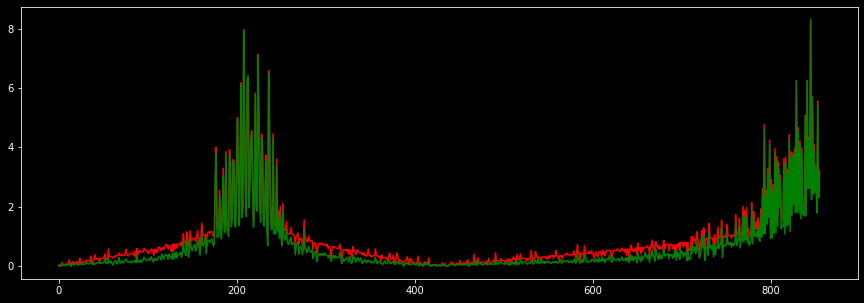

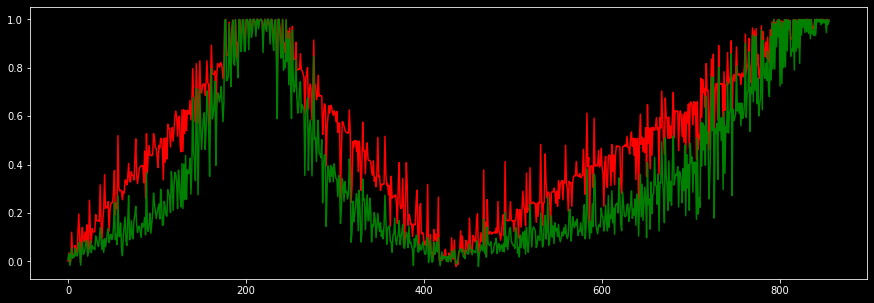

In [765]:
input_shape = x_data_n.shape[1:]
print(input_shape)
input_layer = keras.layers.Input(input_shape)
p_l = keras.layers.Conv1D(filters=32, 
                          kernel_size=6, 
                          padding='same',
                          kernel_initializer='he_uniform')(input_layer)
p_l = keras.layers.Activation('relu')(p_l)
p_l = keras.layers.Conv1D(filters=32, 
                          kernel_size=6, 
                          padding='same',
                          kernel_initializer='he_uniform')(p_l)
p_l = keras.layers.Activation('relu')(p_l)
p_l = keras.layers.Conv1D(filters=32, 
                          kernel_size=6, 
                          padding='same',
                          kernel_initializer='he_uniform')(p_l)
p_l = keras.layers.Activation('relu')(p_l)
p_l = keras.layers.GlobalAveragePooling1D()(p_l)
p_l = keras.layers.Dense(32)(p_l)
p_l = keras.layers.Activation('relu')(p_l)
p_l = keras.layers.Dense(32)(p_l)
p_l = keras.layers.Activation('relu')(p_l)
p_l = keras.layers.Dense(1)(p_l)
# p_l = keras.layers.Activation('tanh')(p_l)
model = keras.models.Model(inputs=input_layer, outputs=p_l)

model_ref = keras.models.load_model('C:\Temp\k2arm\models\cnn_model.h5')
# Layer Conv1D 1
weightsArray = model_ref.layers[1].get_weights()
# weightsArray = weightsCalculation(weightsArray, 0)
model.layers[1].set_weights(weightsArray)
# Layer Conv1D 2
weightsArray = model_ref.layers[3].get_weights()
# weightsArray = weightsCalculation(weightsArray, 0)
model.layers[3].set_weights(weightsArray)
# Layer Conv1D 3
weightsArray = model_ref.layers[5].get_weights()
# weightsArray = weightsCalculation(weightsArray, 0)
model.layers[5].set_weights(weightsArray)
# Layer Dense 1
weightsArray = model_ref.layers[8].get_weights()
# weightsArray = weightsCalculation(weightsArray, 0)
model.layers[8].set_weights(weightsArray)
# Layer Dense 2
weightsArray = model_ref.layers[10].get_weights()
# weightsArray = weightsCalculation(weightsArray, 0)
model.layers[10].set_weights(weightsArray)
# Layer Output Dense
weightsArray = model_ref.layers[12].get_weights()
# weightsArray = weightsCalculation(weightsArray, 0)
model.layers[12].set_weights(weightsArray)


pred_rebuild = model.predict(x_data_n)
print("Max before tanh :", max(pred_rebuild))
print("Min before tanh :", min(pred_rebuild))
# print(pred_rebuild[0])
plt.plot(pred_rebuild, 'r')
plt.plot(final, 'g')
plt.show()

tanh = np.tanh(pred_rebuild)
tanh_final = np.tanh(final)
plt.plot(tanh, 'r')
plt.plot(tanh_final, 'g')
plt.show()

## Model Prediction Vs Expectation

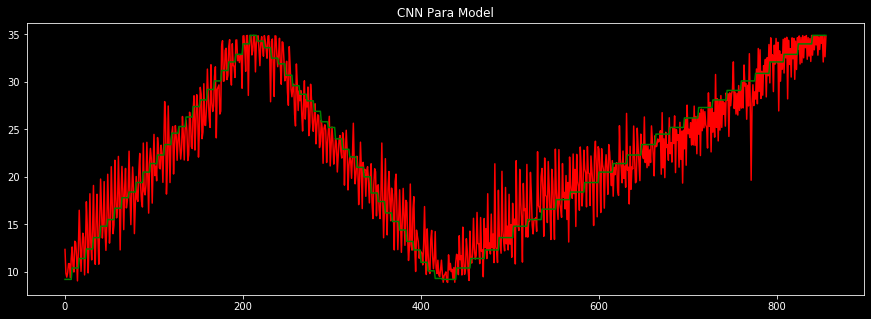

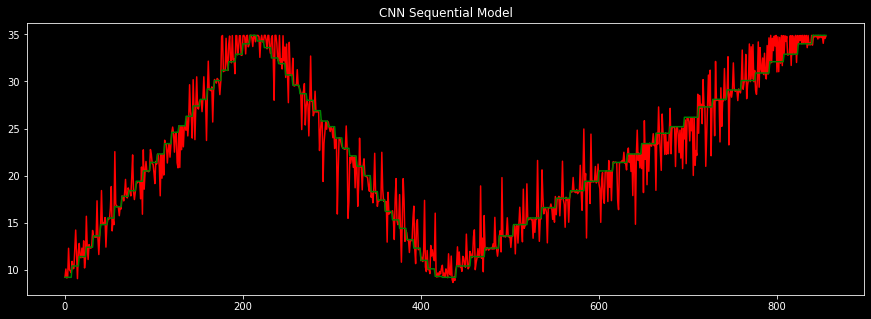

In [768]:
model_ref = keras.models.load_model('C:\Temp\k2arm\models\cnn_model_para.h5')
pred = model_ref.predict(x_data_n)
plt.title("Result Keras")
final = pred * (np.max(y_data) - np.min(y_data)) + np.min(y_data)
plt.plot(final, 'r')
plt.plot(y_data, 'g')
plt.title("CNN Para Model")
plt.show()

model_ref = keras.models.load_model('C:\Temp\k2arm\models\cnn_model_tanh.h5')
pred = model_ref.predict(x_data_n)
plt.title("Result Keras")
final = pred * (np.max(y_data) - np.min(y_data)) + np.min(y_data)
plt.plot(final, 'r')
plt.plot(y_data, 'g')
plt.title("CNN Sequential Model")
plt.show()

## Result CNN 1Conv 1Dense

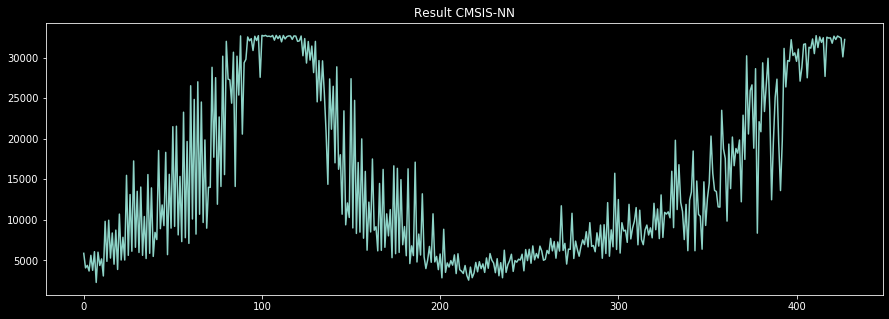

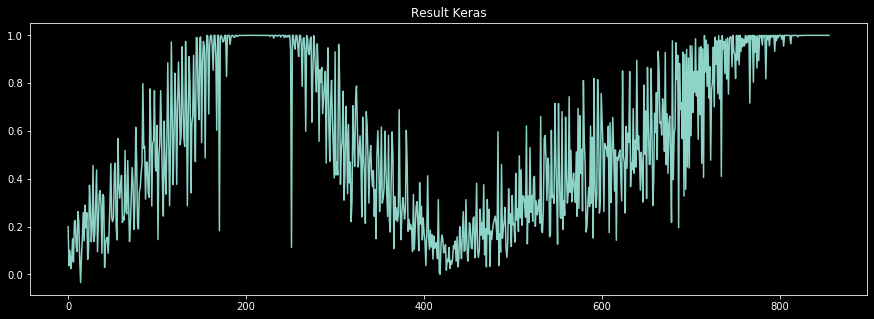

In [383]:
result = [5862, 4059, 4371, 3678, 5612, 3765, 6065, 2267, 6002, 4363, 5167, 3067, 9808, 4871, 9947, 5276, 8372, 4519, 8727, 3868, 10702, 5034, 7842, 5034, 15484, 5612, 13118, 6118, 17261, 6606, 13518, 5963, 14042, 5612, 10403, 5222, 15582, 5862, 13939, 5479, 8446, 7559, 18552, 8905, 11831, 9282, 18322, 5698, 15613, 8972, 21491, 9186, 21550, 8135, 15350, 7308, 23278, 7788, 19666, 7087, 26542, 10097, 24853, 8232, 27030, 10681, 24533, 9667, 19854, 8964, 14010, 14003, 28820, 17720, 27541, 11920, 22690, 14113, 30186, 15576, 32022, 27370, 27271, 24392, 30680, 14113, 30192, 25394, 32691, 20574, 29378, 29804, 32561, 32090, 32354, 30893, 32650, 32123, 32723, 27588, 32759, 32682, 32762, 32629, 32667, 32587, 32750, 32171, 32758, 32360, 32714, 31961, 32748, 32320, 32612, 32692, 32687, 32267, 32696, 32669, 32021, 32082, 32682, 30246, 32364, 29344, 32003, 29707, 31440, 28166, 32017, 24554, 29650, 24695, 29617, 25663, 20788, 14379, 27382, 21179, 26475, 17032, 28877, 16235, 18029, 10688, 23444, 9378, 12076, 10282, 27411, 8994, 24737, 8313, 17072, 8476, 19983, 7727, 15973, 6248, 12178, 8498, 17502, 8713, 9142, 6164, 14482, 6225, 16217, 6606, 10731, 8017, 11258, 5323, 16657, 5815, 16351, 5971, 14955, 6919, 9164, 5565, 16290, 4597, 6782, 5581, 17112, 4793, 8239, 5651, 13206, 5440, 3979, 5050, 6713, 4754, 10738, 4800, 5479, 3845, 5776, 2837, 8831, 3511, 4675, 4168, 4964, 4402, 5667, 3361, 5807, 3837, 3654, 3377, 4355, 3115, 2552, 4160, 2853, 3416, 4738, 3583, 4824, 3971, 4558, 3504, 5292, 4019, 5831, 5019, 4668, 3472, 5198, 3091, 4707, 2845, 6248, 3504, 4457, 4964, 5745, 3630, 4972, 4769, 5136, 5034, 5753, 3702, 6324, 4964, 6362, 4636, 6774, 5058, 5838, 5284, 6751, 6149, 5003, 5120, 6217, 5815, 7704, 6164, 7315, 5261, 7262, 6141, 11728, 6217, 7087, 4535, 6378, 6355, 10802, 5222, 7369, 6324, 5503, 6683, 7521, 6942, 8528, 6652, 9645, 6721, 6820, 6057, 8387, 6751, 9349, 5253, 9393, 5838, 12117, 5503, 8757, 6667, 15741, 6339, 12498, 5893, 9637, 8624, 8713, 7216, 11906, 7636, 9001, 9822, 11507, 6911, 11187, 7559, 6927, 8750, 9349, 8121, 9001, 7773, 12035, 8772, 11336, 7674, 13070, 7826, 10916, 10709, 10980, 10246, 15991, 9031, 19815, 11265, 16797, 12151, 11030, 7559, 11899, 6187, 12430, 13424, 18488, 6179, 14787, 10652, 10439, 6370, 14683, 9304, 12648, 14502, 20331, 15716, 13628, 13486, 11600, 11564, 23513, 18755, 17571, 9837, 19344, 13848, 20212, 16675, 18798, 18226, 19849, 12219, 22909, 17450, 30234, 20589, 25944, 26650, 18836, 28648, 8350, 22104, 20867, 29369, 23363, 26582, 29933, 23521, 12471, 19611, 25096, 27356, 19499, 13608, 19770, 31150, 26394, 29644, 29574, 32225, 30278, 30600, 29558, 31071, 27112, 28822, 31650, 31713, 27524, 31291, 31182, 32315, 30509, 32726, 31259, 32567, 31894, 32466, 27697, 32537, 32431, 32447, 31790, 32660, 32254, 32678, 32555, 32426, 30106, 32252, ]

plt.plot(result)
plt.title("Result CMSIS-NN")
plt.show()

model_ref = keras.models.load_model('C:\Temp\k2arm\models\cnn_model_1c-1d.h5')
pred = model_ref.predict(x_data_n)
plt.title("Result Keras")
plt.plot(pred)
plt.show()

In [1103]:
def plotTestPred(test_labels, test_predictions):
    diff_pred = test_predictions - test_labels
    print("Diff Min = ", diff_pred.min(), " Max = ", diff_pred.max())
    a = plt.axes(aspect='equal')
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    lims = [9, 40]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    plt.show()

# Check result from EMBEDDED SYSTEM

Result min =  -81
Result max =  15681
15680


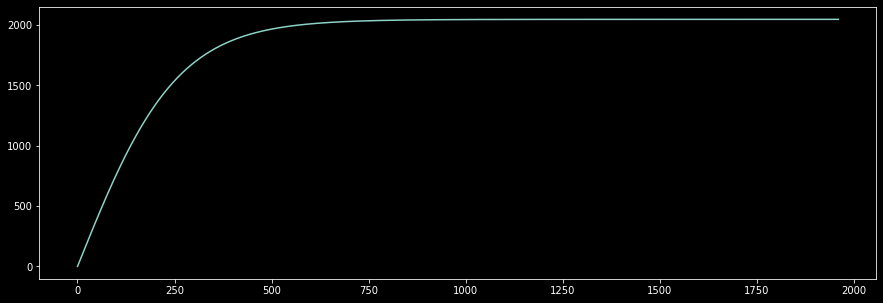

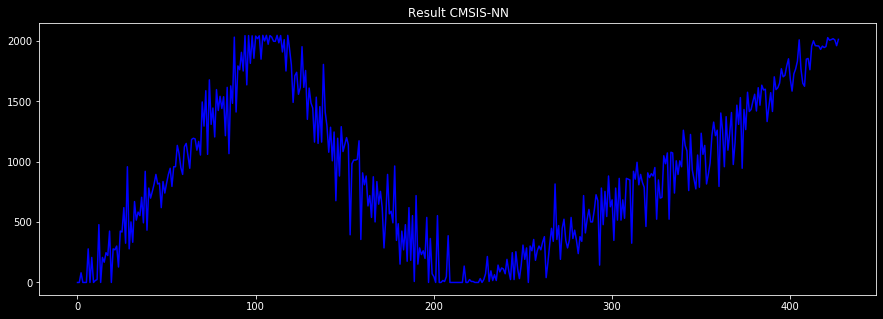

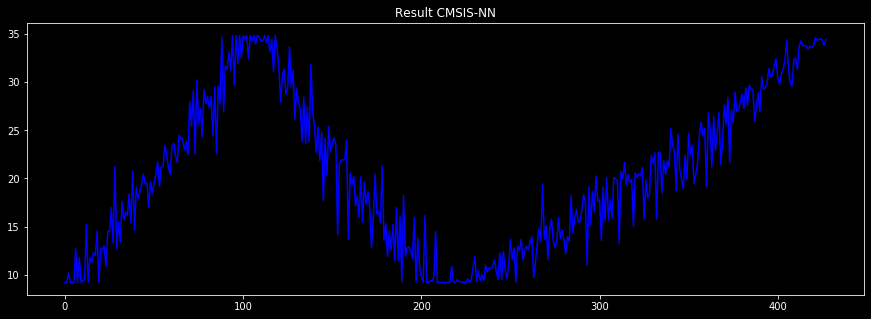

In [1346]:
#result = [9.60, 9.95, 11.54, 10.41, 10.37, 10.61, 13.67, 10.99, 13.89, 12.9, 12.29, 11.27, 16.39, 10.48, 11.60, 11.84, 12.84, 13.56, 14.26, 13.7, 14.99, 14.16, 16.57, 13.77, 15.66, 17.43, 18.85, 15.25, 20.99, 16.8, 16.67, 13.36, 20.75, 16.14, 19.19, 18.54, 19.21, 16.5, 22.62, 18.9, 19.24, 16.81, 19.45, 19.97, 23.69, 17.64, 18.2, 14.91, 18.22, 21.56, 24.15, 21.28, 19.55, 17.82, 22.28, 21.76, 23.41, 22.57, 27.13, 20.28, 23.45, 21.95, 24.8, 19.6, 25.25, 22.94, 24.81, 22.90, 27.54, 23.16, 25.84, 25.38, 28.21, 22.46, 27.71, 23.30, 27.36, 25.16, 27.61, 25.46, 28.81, 25.29, 28.60, 24.84, 29.50, 24.21, 28.47, 26.47, 27.59, 29.41, 30.94, 28.92, 30.35, 28.2, 33.94, 28.1, 29.70, 27.59, 37.72, 30.8, 30.77, 31.20, 33.60, 29.40, 31.15, 32.23, 33.21, 30.56, 35.99, 34.10, 35.86, 31.78, 30.15, 26.45, 32.15, 30.54, 29.72, 31.5, 35.78, 33.9, 31.55, 29.86, 32.36, 29.11, 29.42, 27.6, 30.81, 27.53, 27.57, 23.82, 28.7, 26.82, 29.20, 25.91, 27.73, 24.94, 26.52, 24.75, 27.20, 25.24, 26.39, 23.46, 24.95, 22.43, 24.38, 20.2, 22.65, 21.44, 23.63, 21.55, 25.5, 24.2, 22.98, 20.10, 22.83, 23.77, 22.98, 22.1, 22.52, 14.50, 20.55, 21.31, 18.38, 16.3, 20.35, 17.41, 20.33, 17.44, 21.1, 19.62, 19.17, 18.65, 18.4, 15.56, 20.90, 17.78, 17.93, 16.88, 23.39, 16.58, 16.37, 15.82, 17.72, 15.68, 18.23, 15.29, 21.37, 12.40, 18.7, 11.82, 20.56, 12.69, 15.68, 13.18, 11.48, 14.49, 18.39, 11.37, 15.84, 12.62, 10.67, 11.91, 14.96, 11.10, 10.88, 10.10, 13.85, 13.7, 12.52, 11.37, 9.38, 12.46, 10.77, 10.70, 10.72, 9.88, 10.99, 12.60, 11.63, 10.5, 12.20, 11.78, 11.97, 11.47, 11.28, 10.93, 13.9, 11.58, 12.47, 11.83, 12.28, 12.47, 14.19, 10.44, 10.94, 10.80, 11.46, 12.88, 11.82, 12.58, 12.5, 11.97, 12.45, 11.99, 13.16, 11.9, 14.2, 14.41, 13.5, 13.62, 13.56, 11.55, 14.19, 12.16, 14.84, 14.67, 14.94, 11.46, 16.98, 14.26, 16.1, 15.83, 16.28, 14.6, 16.21, 15.42, 19.35, 15.75, 21.6, 15.54, 16.64, 16.26, 16.28, 15.87, 13.52, 14.0, 19.55, 17.33, 15.81, 15.90, 18.85, 12.80, 16.38, 14.6, 16.44, 17.10, 18.2, 14.57, 21.29, 18.92, 19.2, 18.28, 18.57, 15.56, 17.69, 18.43, 19.86, 16.66, 17.42, 19.35, 21.93, 15.21, 19.92, 13.32, 20.84, 21.19, 19.47, 19.18, 20.22, 20.29, 18.72, 17.6, 20.41, 18.87, 19.33, 20.26, 22.14, 20.41, 20.0, 19.68, 21.45, 17.45, 22.12, 22.32, 20.73, 23.30, 22.5, 17.28, 18.1, 22.86, 22.82, 22.80, 22.11, 23.63, 23.23, 19.76, 23.57, 20.44, 21.6, 22.35, 22.83, 22.68, 24.2, 19.1, 23.5, 19.91, 21.41, 20.43, 23.44, 21.67, 23.44, 19.26, 23.39, 23.10, 22.2, 20.58, 22.24, 25.25, 26.39, 24.12, 9.47, 23.36, 24.95, 23.94, 22.86, 23.0, 27.44, 25.65, 24.96, 25.17, 26.64, 24.23, 28.17, 24.25, 26.97, 27.20, 26.3, 27.4, 30.55, 25.13, 27.96, 27.33, 28.18, 27.91, 28.18, 27.40, 28.59, 26.1, 27.33, 28.71, 26.59, 26.13, 25.3, 25.84, 27.94, 25.10, 28.85, 28.37, 27.82, 27.61, 28.51, 26.50, 29.14, 27.74, 31.54, 28.58, 30.52, 30.0, 29.38, 32.2, 28.95, 29.82, 32.58, 38.48, 32.2, 33.64, 31.75, 30.97, 29.18, 33.41, 29.57, 31.56, 32.73, 28.87, 31.95, 32.1, 32.60, 31.46, ]
result = [-81, -29, 84, -25, -39, -17, 284, -81, 210, -15, 19, 29, 493, -21, 210, 171, 249, 228, 434, -10, 284, 278, 305, 131, 437, 429, 642, 334, 1046, 285, 515, 343, 696, 530, 600, 575, 740, 505, 995, 446, 826, 731, 798, 867, 967, 869, 872, 642, 889, 781, 876, 966, 1024, 847, 1042, 1040, 1281, 1189, 1037, 960, 1269, 1306, 1165, 1026, 1352, 1369, 1362, 1227, 1329, 1175, 1908, 1530, 2126, 1178, 2375, 1554, 1800, 1389, 2149, 1764, 2013, 1796, 2007, 1401, 2198, 1191, 2225, 1887, 5766, 1741, 2787, 2662, 3419, 2616, 7582, 2255, 7983, 2887, 7160, 3096, 6735, 5126, 7147, 3057, 15681, 4571, 11950, 4103, 7893, 5782, 4531, 4512, 13504, 4282, 8107, 3443, 4858, 2616, 12360, 3657, 2829, 1899, 2483, 2582, 2054, 2189, 3840, 2192, 2632, 1629, 2181, 1894, 1801, 1325, 1996, 1308, 1826, 1321, 2845, 1736, 1534, 1200, 1512, 1107, 1450, 706, 1370, 948, 1521, 1210, 1288, 1378, 1294, 407, 1078, 1118, 1119, 1123, 1337, 366, 978, 859, 949, 663, 759, 558, 939, 516, 892, 678, 794, 642, 291, 550, 963, 591, 613, 506, 1049, 357, 499, 154, 437, 278, 494, 180, 647, 190, 568, 10, 758, 158, 292, 239, 271, 200, 554, -40, 369, 73, 50, -7, 568, -47, -44, 18, 13, 53, 393, -60, -17, -69, -25, -57, -57, -59, -36, 138, -75, -70, 31, 12, 15, -51, -54, 2, 33, -2, 29, 78, 216, 12, 99, 19, 68, 23, 146, 92, 123, 113, 72, 196, 99, 31, 250, 28, 262, 115, 39, 148, 312, 196, 295, 3, 311, 264, 363, 189, 267, 305, 275, 336, 388, 44, 170, 320, 461, 345, 866, 362, 485, 196, 462, 537, 359, 290, 354, 558, 368, 443, 359, 241, 390, 344, 759, 422, 543, 628, 514, 515, 616, 767, 707, 146, 826, 488, 797, 567, 947, 649, 715, 354, 826, 534, 927, 534, 714, 546, 926, 915, 908, 328, 993, 919, 1089, 857, 964, 881, 834, 472, 977, 928, 973, 949, 1034, 536, 907, 733, 736, 1161, 1073, 1197, 543, 1206, 1195, 779, 1109, 962, 1105, 1040, 1477, 1284, 1217, 804, 1423, 1012, 912, 820, 1170, 837, 1438, 1177, 1281, 864, 965, 1084, 1402, 1586, 1401, 1476, 846, 1720, 1478, 1046, 1667, 1225, 1433, 1734, 1067, 1318, 1849, 1553, 1984, 1025, 1776, 1482, 2091, 1746, 1779, 1914, 2054, 1758, 2190, 1853, 2246, 2143, 2152, 1599, 1831, 2081, 1749, 2448, 2149, 2185, 2295, 2692, 2454, 2493, 2790, 3079, 2388, 2112, 2528, 2684, 2969, 4806, 2679, 2295, 2220, 3060, 3091, 2660, 3891, 4605, 3944, 3935, 3904, 3621, 3901, 3768, 3851, 5515, 4721, 4859, 5113, 4784, 3940, 4925, ]
#result = [0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 7, 0, 7, 7, 7, 0, 7, 7, 15, 7, 31, 7, 15, 7, 15, 15, 15, 15, 15, 7, 23, 7, 23, 15, 23, 23, 23, 23, 23, 15, 23, 23, 23, 23, 31, 23, 31, 31, 39, 31, 31, 23, 31, 39, 31, 31, 39, 39, 39, 31, 39, 31, 55, 39, 63, 31, 71, 47, 55, 39, 63, 47, 55, 55, 55, 39, 63, 31, 63, 55, 175, 47, 79, 79, 103, 79, 231, 63, 246, 87, 215, 95, 207, 159, 215, 87, 478, 135, 364, 127, 238, 175, 135, 135, 410, 127, 246, 103, 143, 79, 379, 111, 87, 55, 71, 79, 63, 63, 119, 63, 79, 47, 63, 55, 55, 39, 55, 39, 55, 39, 87, 47, 39, 31, 39, 31, 39, 15, 39, 23, 39, 31, 39, 39, 39, 7, 31, 31, 31, 31, 39, 7, 23, 23, 23, 15, 15, 15, 23, 15, 23, 15, 23, 15, 7, 15, 23, 15, 15, 7, 31, 7, 7, 0, 7, 7, 7, 0, 15, 0, 15, 0, 15, 0, 7, 0, 7, 0, 15, 0, 7, 0, 0, 0, 15, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 7, 0, 7, 0, 7, 7, 7, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 23, 7, 7, 0, 7, 15, 7, 7, 7, 15, 7, 7, 7, 0, 7, 7, 15, 7, 15, 15, 15, 15, 15, 15, 15, 0, 23, 7, 23, 15, 23, 15, 15, 7, 23, 15, 23, 15, 15, 15, 23, 23, 23, 7, 23, 23, 31, 23, 23, 23, 23, 7, 23, 23, 23, 23, 31, 15, 23, 15, 15, 31, 31, 31, 15, 31, 31, 23, 31, 23, 31, 31, 39, 39, 31, 23, 39, 23, 23, 23, 31, 23, 39, 31, 39, 23, 23, 31, 39, 47, 39, 39, 23, 47, 39, 31, 47, 31, 39, 47, 31, 39, 55, 47, 55, 31, 47, 39, 63, 47, 47, 55, 63, 47, 63, 55, 63, 63, 63, 47, 55, 63, 47, 71, 63, 63, 63, 79, 71, 71, 79, 95, 71, 63, 71, 79, 87, 143, 79, 63, 63, 87, 95, 79, 119, 135, 119, 119, 119, 111, 119, 111, 119, 167, 143, 143, 151, 143, 119, 151, ]

result = np.asarray(result)

print("Result min = ", result.min())
print("Result max = ", result.max())

tanh_x = np.arange(0, result.max(), 8)
print(tanh_x.max())

tanh_y = tanh_x / 2**11
tanh_y = np.tanh(tanh_y)

tanh_y = tanh_y * 2**11

index = result / 2**3
index = index.astype(int)

index[index < 0] = 0
index[index >= len(tanh_y)] = len(tanh_y)-1
res_tanh = tanh_y[index]

plt.plot(tanh_y)
plt.show()

y_data_half = []
idx = 0
for i in range(0, len(y_data), 2):
    y_data_half = np.append(y_data_half, y_data[i])
    
# plotTestPred(y_data_half, result_flow)

plt.plot(res_tanh, 'b')
#plt.plot(result_tanh, 'r')
plt.title("Result CMSIS-NN")
plt.show()

result = [9.19, 9.19, 10.18, 9.19, 9.19, 9.19, 12.68, 9.19, 11.79, 9.19, 9.38, 9.48, 15.19, 9.19, 11.79, 11.29, 12.28, 11.99, 14.53, 9.19, 12.68, 12.58, 12.97, 10.79, 14.53, 14.44, 16.96, 13.27, 21.22, 12.68, 15.48, 13.37, 17.60, 15.67, 16.51, 16.13, 18.4, 15.39, 20.75, 14.63, 19.1, 17.95, 18.66, 19.43, 20.42, 19.43, 19.51, 16.96, 19.68, 18.48, 19.51, 20.42, 21.7, 19.17, 21.22, 21.22, 23.44, 22.58, 21.14, 20.42, 23.30, 23.65, 22.37, 21.7, 24.5, 24.19, 24.13, 22.95, 23.85, 22.43, 27.95, 25.46, 29.13, 22.51, 30.25, 25.63, 27.33, 24.32, 29.25, 27.8, 28.54, 27.28, 28.51, 24.45, 29.49, 22.58, 29.62, 27.82, 34.71, 26.91, 31.71, 31.32, 33.13, 31.18, 34.86, 29.74, 34.87, 31.97, 34.84, 32.51, 34.82, 34.54, 34.84, 32.41, 34.88, 34.31, 34.88, 33.97, 34.87, 34.71, 34.28, 34.27, 34.88, 34.12, 34.87, 33.16, 34.44, 31.18, 34.88, 33.48, 31.82, 27.92, 30.70, 31.4, 28.76, 29.45, 33.70, 29.49, 31.23, 26.15, 29.40, 27.87, 27.33, 23.79, 28.46, 23.65, 27.48, 23.79, 31.87, 26.91, 25.46, 22.73, 25.33, 21.84, 24.83, 17.69, 24.19, 20.26, 25.40, 22.80, 23.51, 24.25, 23.51, 14.14, 21.53, 21.92, 21.92, 21.99, 23.93, 13.66, 20.59, 19.35, 20.26, 17.15, 18.22, 15.96, 20.17, 15.48, 19.68, 17.33, 18.66, 16.96, 12.78, 15.86, 20.42, 16.32, 16.60, 15.39, 21.30, 13.56, 15.29, 11.9, 14.53, 12.58, 15.19, 11.39, 16.96, 11.49, 16.13, 9.28, 18.22, 11.9, 12.78, 12.9, 12.48, 11.69, 15.96, 9.19, 13.76, 10.8, 9.78, 9.19, 16.13, 9.19, 9.19, 9.38, 9.28, 9.78, 14.5, 9.19, 9.19, 9.19, 9.19, 9.19, 9.19, 9.19, 9.19, 10.89, 9.19, 9.19, 9.48, 9.28, 9.28, 9.19, 9.19, 9.19, 9.58, 9.19, 9.48, 10.8, 11.89, 9.28, 10.39, 9.38, 9.98, 9.38, 10.99, 10.29, 10.69, 10.59, 10.8, 11.59, 10.39, 9.48, 12.28, 9.48, 12.38, 10.59, 9.58, 10.99, 13.7, 11.59, 12.78, 9.19, 12.97, 12.48, 13.66, 11.49, 12.48, 12.97, 12.58, 13.37, 13.95, 9.68, 11.29, 13.17, 14.82, 13.46, 19.43, 13.66, 15.10, 11.59, 14.82, 15.77, 13.56, 12.78, 13.56, 15.96, 13.76, 14.63, 13.56, 12.18, 13.95, 13.46, 18.22, 14.34, 15.77, 16.79, 15.48, 15.48, 16.70, 18.30, 17.69, 10.99, 19.1, 15.19, 18.66, 16.5, 20.26, 17.6, 17.78, 13.56, 19.1, 15.67, 20.1, 15.67, 17.78, 15.86, 20.1, 19.94, 19.85, 13.27, 20.75, 19.94, 21.69, 19.35, 20.42, 19.60, 19.9, 15.0, 20.59, 20.10, 20.50, 20.26, 21.14, 15.77, 19.85, 17.95, 18.4, 22.37, 21.53, 22.66, 15.77, 22.73, 22.66, 18.48, 21.84, 20.42, 21.84, 21.22, 25.2, 23.44, 22.87, 18.74, 24.58, 20.90, 19.94, 18.92, 22.43, 19.9, 24.70, 22.51, 23.44, 19.43, 20.42, 21.60, 24.45, 25.86, 24.45, 25.2, 19.17, 26.81, 25.2, 21.22, 26.44, 22.95, 24.70, 26.86, 21.45, 23.71, 27.63, 25.63, 28.42, 21.7, 27.18, 25.8, 28.97, 26.96, 27.18, 28.0, 28.76, 27.3, 29.45, 27.63, 29.70, 29.21, 29.28, 25.92, 27.48, 28.93, 26.96, 30.58, 29.25, 29.45, 29.91, 31.42, 30.58, 30.73, 31.71, 32.45, 30.33, 29.8, 30.88, 31.39, 32.21, 34.42, 31.37, 29.91, 29.60, 32.41, 32.49, 31.32, 33.76, 34.32, 33.82, 33.80, 33.78, 33.43, 33.76, 33.63, 33.72, 34.66, 34.38, 34.44, 34.54, 34.42, 33.82, 34.47, ]

plt.plot(result, 'b')
#plt.plot(result_tanh, 'r')
plt.title("Result CMSIS-NN")
plt.show()